# STARmap

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import BINARY

In [4]:
import pysodb
sodb = pysodb.SODB()
adata_dict = sodb.load_dataset('Dataset11_MS_raw')
adata_raw = list(adata_dict.values())[0]

load experiment[Dataset11] in dataset[Dataset11_MS_raw]


In [5]:
adata_raw

AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'ct', 'gt', 'slice_id', 'batch'
    uns: 'moranI', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [6]:
adata = BINARY.clean_adata(adata_raw, save_obs=['gt', 'slice_id'])

In [7]:
adata

AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'gt', 'slice_id'
    obsm: 'spatial'

In [8]:
print(np.unique(adata.obs['slice_id']))

['BZ14' 'BZ5' 'BZ9']


In [9]:
adata = adata[adata.obs['slice_id']=='BZ5']

In [10]:
adata

View of AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'gt', 'slice_id'
    obsm: 'spatial'

In [11]:
adata.var_names_make_unique()


In [12]:
adata = BINARY.Count2Binary(adata)

In [13]:
BINARY.Construct_Spatial_Graph(adata, use_method='KNN', cutoff=14)

------Constructing spatial graph...------
The graph contains 14686 edges, 1049 cells.
14.0000 neighbors per cell on average.


In [14]:
adata = BINARY.train_BINARY(adata, pos_weight = 10, device= 'cuda:0')

Size of Input:  (1049, 166)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 179.25it/s]


In [15]:
sc.pp.neighbors(adata, use_rep='BINARY')
sc.tl.umap(adata)

In [16]:
adata = BINARY.mclust_R(adata, used_obsm='BINARY', num_cluster=4)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [17]:
adata

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'gt', 'slice_id', 'mclust'
    uns: 'Spatial_Net', 'neighbors', 'umap'
    obsm: 'spatial', 'BINARY', 'X_umap'
    obsp: 'distances', 'connectivities'

In [18]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df["gt"])
print('ARI = %.2f' %ARI)

Adjusted rand index = 0.76


In [19]:
NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['gt'])
print('NMI = %.2f' % NMI)

NMI = 0.72


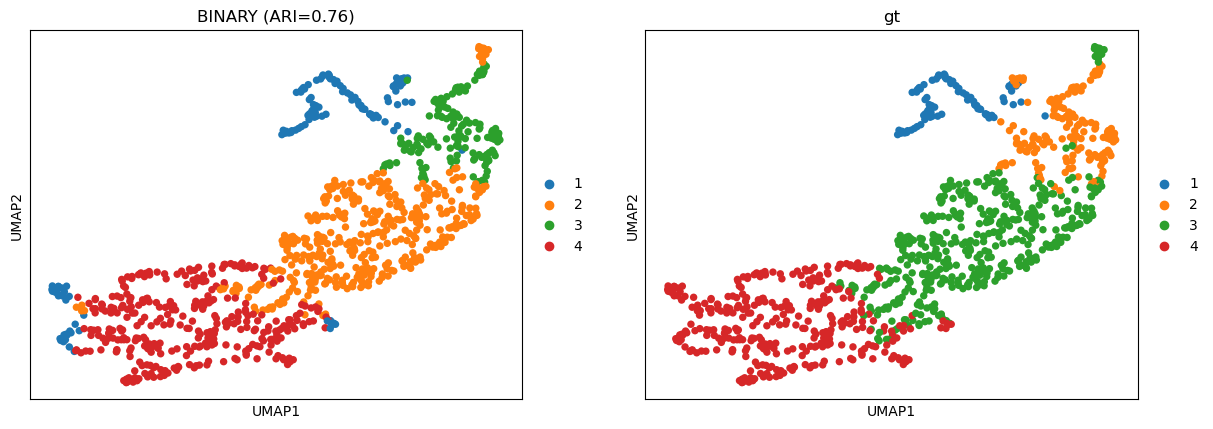

In [20]:
sc.pl.umap(adata, color=["mclust", 'gt'], title=['BINARY (ARI=%.2f)'%ARI, "gt"])

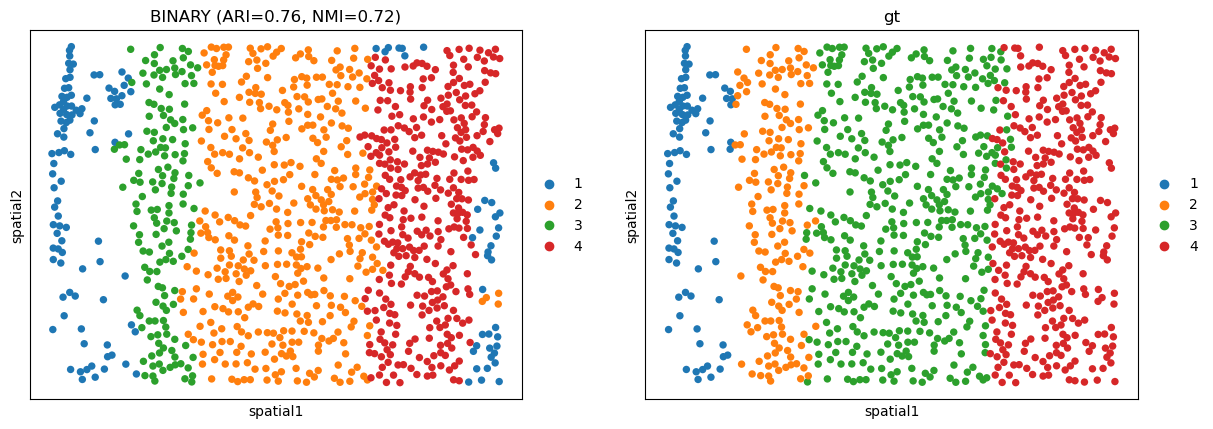

In [22]:
sc.pl.embedding(adata, basis='spatial', color=['mclust', "gt"], title=['BINARY (ARI=%.2f, NMI=%.2f)'%(ARI, NMI), "gt"])

In [23]:
new_type = BINARY.Refine_label(adata, radius=30, key='mclust')
adata.obs['domain'] = new_type 

In [24]:
obs_df = adata.obs.dropna()
refine_ARI = adjusted_rand_score(obs_df['domain'], obs_df['gt'])
print('Refine ARI = %.2f' %refine_ARI)

Refine ARI = 0.80


In [25]:
refine_NMI = normalized_mutual_info_score(obs_df['domain'], obs_df['gt'])
print('NMI = %.2f' %refine_NMI)

NMI = 0.79


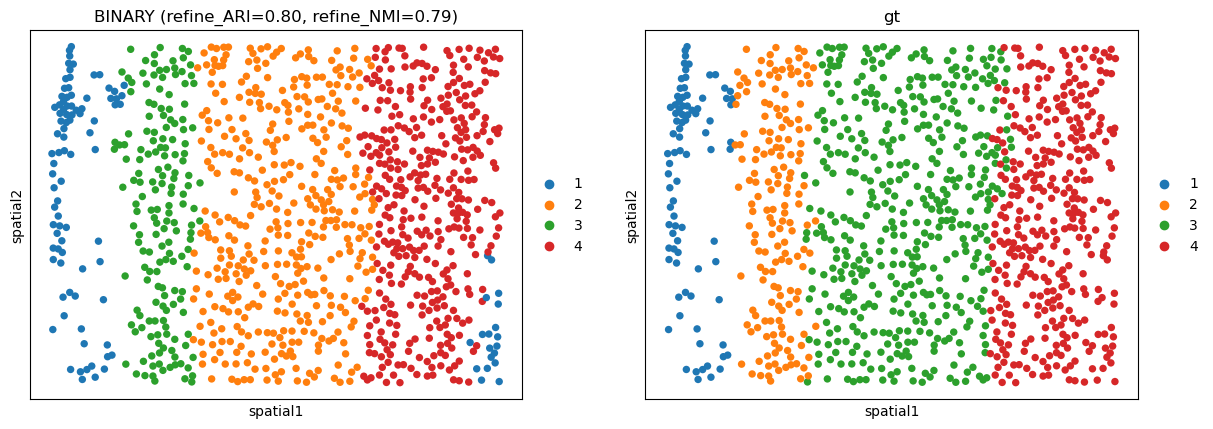

In [26]:
sc.pl.embedding(adata, basis='spatial', color=['domain', "gt"], title=['BINARY (refine_ARI=%.2f, refine_NMI=%.2f)'%(refine_ARI, refine_NMI), "gt"])